In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import erf
import astropy.units as unit
import astropy.constants as const
import itertools
import plotly.express as px 
import pandas as pd
from scipy.special import factorial as fact
from scipy.optimize import root_scalar

from axion_functions import *

In [2]:
#Define constants
a = 6.642 #Lattice constant, Angstroms = 1e-10m, from Dent paper. 
hbar_kevs = (const.hbar.to(unit.keV*unit.s)).value #hbar, keV*s, from astropy
c_aas = (const.c.to(unit.AA/unit.s)).value #speed of light, angstrom/s (cancels with a), from astropy

# Define unknown constants
#g_ag = 2e-10 #Axion-photon coupling (Primakoff process), in GeV^(-1).
#Upper bound on g_ag of 2.7e-10 from the Sun, see Di Luzio's review
#lmda = (g_ag/(1e-8))**4
phi_0 = 5.95e14 #in cm^(-2) s^(-1)
E_0    = 1.103 #in keV

#Crystal Geometry
#diam = 110*unit.mm
#hgt = 250*unit.mm 
#vol = ((np.pi*(diam/2)**2*hgt).to(unit.AA**3)).value 
#mass = 5*unit.t #Mass for ton-scale NaI
mass = 50*unit.kg
vol = ((mass/(3.67*unit.g*(unit.cm)**(-3))).to(unit.AA**3)).value #Crystal volume, in AA^3
#Make volume make the mass like 7kg
vol_cell = 67.71 #In AA^3, from Dent paper
t_exposure = 3

s_in_y = 365.25*24*60*60 #Number of seconds in a year

In [3]:
def complete_dndt(max_hkl = 5, print_output = False, condition = "all even", k=[1,0,0], abs_forgot = True, coupling=2e-10, time=3, m_a=0.01, return_energy = False):
    "Axion mass is in keV"
    if condition == "sum even":
        hkl = np.array(make_hkl_s(max_h = max_hkl, 
                                max_k = max_hkl,
                                max_l = max_hkl))
    elif condition == "all even":
        hkl = np.array(make_hkl_double(max_h = max_hkl, 
                                  max_k = max_hkl,
                                  max_l = max_hkl))
    elif condition == "all":
        hkl = np.array(list(itertools.product(range(max_hkl),
                                              range(max_hkl),
                                              range(max_hkl))))[1:]
    else:
        raise NameError("Condition is not one of 'sum even', 'all even', or 'all'")
        
    g_ag = coupling

    g_arr = (2*np.pi/a)*hkl #G vectors, in AA^(-1)

    mod2_g = mod2(g_arr) #Magnitude square of G vectors, 
    FAq_Na = FA_qv2(mod2_g, Z=11)
    FAq_I  = FA_qv2(mod2_g, Z=53)

    ginv_array = 1/mod2_g

    ginv_replicant = np.stack((ginv_array, ginv_array,ginv_array), axis=1)

    ghat = g_arr*np.sqrt(ginv_replicant) # Correct

    if abs_forgot:
        gk = np.abs(gdotk_cart(hkl_to_cart(ghat), k/cart_mag(np.array(k)))) #correct
    else:
        gk = gdotk_cart(hkl_to_cart(ghat), k/cart_mag(np.array(k)))

    sin2 = 4*gk**2*(1-gk**2) 

    if condition == "all even":
        summand = ((FAq_Na+FAq_I)**2)*ginv_array*sin2*64 #*4 from S, *4 from form factor F
    elif condition == "sum even":
        summand = ((FAq_Na+FAq_I)**2)*ginv_array*sin2*4 #Use *4 if implementing s
    else:
        summand = []
        for hkls in hkl:
            if sum(hkls)%2==0: #Even, Constructive sum
                faq_part = (FA_qv2(mod2_hkl_solo((2*np.pi/a)*hkls), Z=11) + FA_qv2((2*np.pi/a)**2*mod2_hkl_solo(hkls), Z=53))**2
            else: #Odd, destructive
                faq_part = (FA_qv2(mod2_hkl_solo((2*np.pi/a)*hkls), Z=11) - FA_qv2((2*np.pi/a)**2*mod2_hkl_solo(hkls), Z=53))**2    
            summand.append(faq_part/mod2_hkl_solo(2*np.pi/a*hkls)*sin2)
        summand = np.array(summand)

    E_arr = hbar_kevs*c_aas*np.sqrt(mod2_g)/(2*gk) #in keV 
    #The infinities here are fine; they go to zero in the W function

    W = w_func(E_arr, E1=1, E2=50, dVector=True, Delta = make_delta(E_arr)) #Delta from Simulation of BG report
    
    #W = w_func(E_arr, E1=1, E2=50, dVector=False, Delta = 1) #Delta from Simulation of BG report
    
    dphi_de = primakoff_flux(E_arr, coupling=g_ag, m_a = m_a) + coalescence_flux(E_arr, coupling=g_ag, m_a = m_a)
    final_summand = W*dphi_de*1e-16*summand #1e-16 to cancel angstroms and cm squared

    nt_constant = np.pi*(g_ag*1e-6)**2*(hbar_kevs*c_aas)**3*vol/(vol_cell**2) #in keV
    if return_energy:
        dct = {"G"   : mod2_g,
               "sin2": sin2,
               "E"   : E_arr,
               "Rate": nt_constant*final_summand
               }
        return pd.DataFrame(dct)
    else:
        final_dndt = nt_constant*np.sum(final_summand) #in s^(-1), 1e-16 converts angstroms and cm
        if print_output:
            print("dN/dt = {:.3e} s^(-1)".format(final_dndt))
        return final_dndt*s_in_y*time

def theta_funcd(theta_func, phi, g_ag=2e-10):
    output = []
    for p in phi:
        k_vec = k_from_polar(theta_func(p), p)
        output.append(complete_dndt(abs_forgot = True, all_even=True, coupling = g_ag, k=k_vec))
    return np.array(output)

def line_integral(theta_func, phi, g_ag=2e-10, t=3, m_a = 0.01):
    dphi = np.diff(phi)
    integral = 0
    for index in range(len(phi)-1):
        p = phi[index]
        k_vec = k_from_polar(theta_func(p), p)
        integral += complete_dndt(abs_forgot = True, condition = "all even", k=k_vec, time=t, coupling=g_ag, m_a = m_a)*dphi[index]
    return integral

cosine_fits = pd.read_csv("..\\cosine_fits.csv", index_col=0)
def cosine_func(x, amp, phase, vert):
    return amp*np.cos((x-np.pi/180*phase))+vert
fits = np.array(cosine_fits[["a","p","v"]])

def annual_change(coupling = 5.5e-11, time=10, m_a = 0.01):
    output = []
    phi_axis = np.arange(0, 2*np.pi, 0.01)
    for triplet in fits:
        theta_phi = lambda x: cosine_func(x, *triplet)
        output.append(line_integral(theta_phi, phi_axis, g_ag = coupling, t=time, m_a = m_a))
    return np.array(output)

Run the annual code for M = 1keV, M = 5 keV, M=10 keV. I could do an overnight run some other point.

In [32]:
#used_g = 1.23e-10 
#annuals_dict["1"] = annual_change(coupling = used_g, time=t_exposure, m_a = 1 )
#annuals_dict["5"] = annual_change(coupling = used_g, time=t_exposure, m_a = 5 )
#annuals_dict["10"]= annual_change(coupling = used_g, time=t_exposure, m_a = 10)

C:\Users\taase\AppData\Local\Temp\ipykernel_16272\998607317.py:53: RuntimeWarning: divide by zero encountered in divide
  E_arr = hbar_kevs*c_aas*np.sqrt(mod2_g)/(2*gk) #in keV
c:\Users\taase\OneDrive\Documents\School\Unimelb\Winter Project\Axion-Flux\Code\axion_functions.py:134: RuntimeWarning: overflow encountered in exp
  val = np.sqrt(lmda)*phi_e0*E*(E**2 - m_a**2)/(np.exp(E/1.1) - 0.7)*(1+0.02*m_a)


In [24]:
used_g = 1.23e-10 
used_m = 5
lines_annual = annual_change(coupling = used_g, time=t_exposure, m_a = used_m)

C:\Users\taase\AppData\Local\Temp\ipykernel_16272\998607317.py:53: RuntimeWarning: divide by zero encountered in divide
  E_arr = hbar_kevs*c_aas*np.sqrt(mod2_g)/(2*gk) #in keV
c:\Users\taase\OneDrive\Documents\School\Unimelb\Winter Project\Axion-Flux\Code\axion_functions.py:134: RuntimeWarning: overflow encountered in exp
  val = np.sqrt(lmda)*phi_e0*E*(E**2 - m_a**2)/(np.exp(E/1.1) - 0.7)*(1+0.02*m_a)


Text(0, 0.5, 'Rate (Counts per 10 years)')

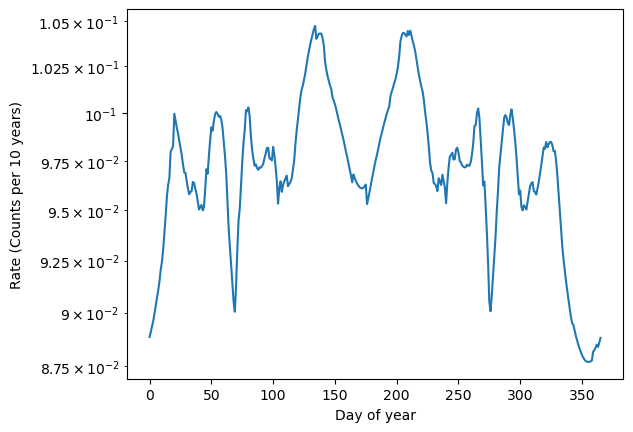

In [54]:
fig, ax = plt.subplots()
#ax.plot(range(0,366), annuals_dict["1"]/(2*np.pi))
#ax.plot(range(0,366), annuals_dict["5"]/(2*np.pi))
#ax.plot(range(0,366), annuals_dict["10"]/(2*np.pi))
ax.set_yscale("log")
plt.xlabel("Day of year")
plt.ylabel("Rate (Counts per 10 years)")
#ax.hlines(3.007534546581472, 0, 366, color="black")

In [60]:
mean = np.trapz(annuals_dict["10"]/(2*np.pi), np.linspace(0, 366, len(lines_annual)))/(366)
mean

0.09712439236060606

In [61]:
used_g*(np.log(20)/mean)**(1/4)

2.89867004352429e-10

In [50]:
annual_df = pd.DataFrame.from_dict(annuals_dict, orient="index").transpose()
annual_df = (annual_df.drop("2", axis=1)).drop("3", axis=1)

In [71]:
complete_df = complete_dndt(return_energy = True)
complete_df

C:\Users\taase\AppData\Local\Temp\ipykernel_16272\3378474792.py:53: RuntimeWarning: divide by zero encountered in divide
  E_arr = hbar_kevs*c_aas*np.sqrt(mod2_g)/(2*gk) #in keV


,G,sin2,E,Rate
0,10.738491,0.888889,5.600009,2.626854e-08
1,42.953962,0.888889,11.200018,2.287221e-09
2,10.738491,0.888889,5.600009,2.626854e-08
3,14.317987,0.000000,3.733339,0.000000e+00
4,39.374465,0.595041,6.844455,1.809147e-08
5,42.953962,0.888889,11.200018,2.287221e-09
6,39.374465,0.595041,6.844455,1.809147e-08
7,57.271950,0.000000,7.466679,0.000000e+00
8,10.738491,0.888889,5.600009,2.626854e-08
9,14.317987,0.000000,inf,0.000000e+00


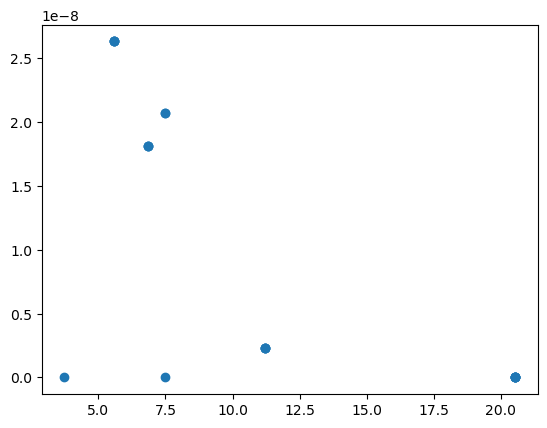

In [73]:
plt.scatter(complete_df["E"], complete_df["Rate"])

In [4]:
phi_axis =  np.arange(0, 2*np.pi, 0.025)
theta_axis = np.arange(0,np.pi,   0.025)
angle_plane = np.array(list(itertools.product(phi_axis, theta_axis)))

def angle_dependence(g_ag = 2e-10, t=3, mass = 0.01):
    outputs = []
    for angles in angle_plane:
        phi = angles[0]
        theta = angles[1]
        k_vec = [np.sin(theta)*np.cos(phi), np.sin(theta)*np.sin(phi), np.cos(theta)]
        outputs.append(complete_dndt(k = k_vec, abs_forgot = True, condition="all even", coupling = g_ag, time=t, m_a = mass))
    return np.array(outputs)

rates_on_angle = angle_dependence(g_ag = 1e-10, t=3, mass = 0.01)
rates_square = np.reshape(rates_on_angle, (len(phi_axis), len(theta_axis)))

C:\Users\taase\AppData\Local\Temp\ipykernel_19552\3378474792.py:53: RuntimeWarning: divide by zero encountered in divide
  E_arr = hbar_kevs*c_aas*np.sqrt(mod2_g)/(2*gk) #in keV
c:\Users\taase\OneDrive\Documents\School\Unimelb\Winter Project\Axion-Flux\Code\axion_functions.py:134: RuntimeWarning: overflow encountered in exp
  val = np.sqrt(lmda)*phi_e0*E*(E**2 - m_a**2)/(np.exp(E/1.1) - 0.7)*(1+0.02*m_a)


In [18]:
import matplotlib 
matplotlib.rcParams.update({"text.usetex": True})

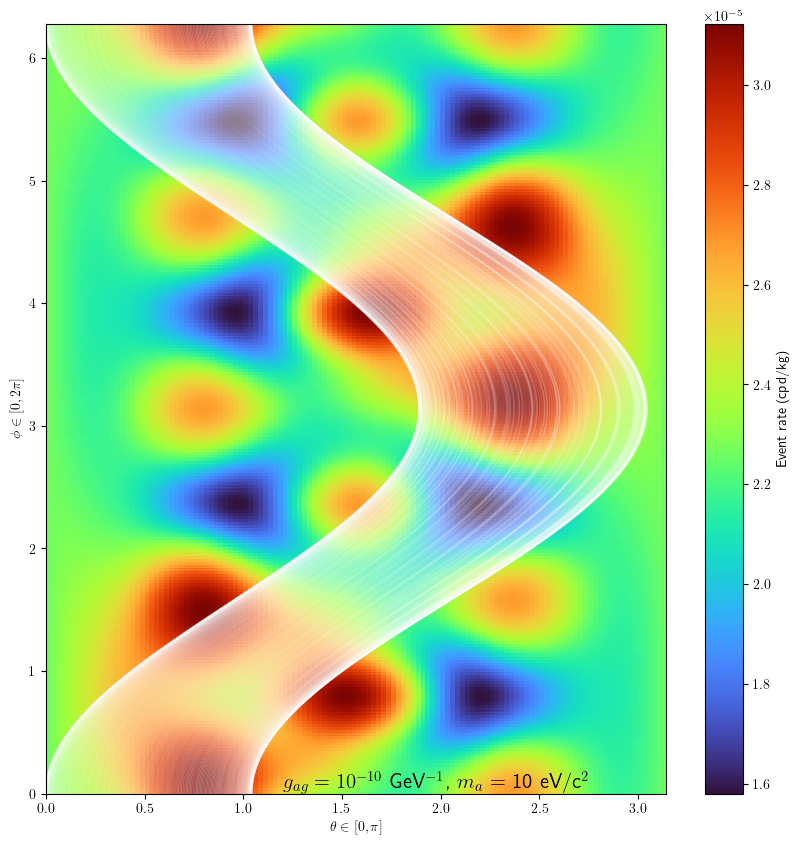

In [22]:
fig,ax = plt.subplots(figsize=(10,10))
cpd = rates_square/(3*s_in_y)*86400/50
image = ax.imshow(cpd, interpolation='none', extent = (0,np.pi,0,2*np.pi), aspect='auto', origin='lower', cmap='turbo')
#path = ax.plot(theta_phi(phi_axis), phi_axis, c="white")
#ax.scatter(alt_polar, az_rad, c="magenta")

phi_axis = np.arange(0, 2*np.pi, 0.01)
for triplet in fits:
    ax.plot(np.pi/2-cosine_func(phi_axis, *triplet), phi_axis, c="white", alpha=0.15)#

ax.set_xlim([0, np.pi])

cbar = plt.colorbar(image)
cbar.set_label("Event rate (cpd/kg)")
#plt.title("Dual Condition (h,k,l even)")
plt.text(1.2, 0.05, "$g_{ag} = 10^{-10}$ GeV$^{-1}$, $m_a$ = 10 eV/c$^2$", color="black", fontsize=15)
plt.xlabel("$\\theta \in [0,\pi]$")
plt.ylabel("$\phi \in [0,2\pi]$")
plt.savefig("Plots\\angle_dependence_v3.png", dpi=300, bbox_inches="tight")
plt.show()